In [33]:
# Data Set: FD001
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD002
# Train trajectories: 260
# Test trajectories: 259
# Conditions: SIX 
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD003
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

# Data Set: FD004
# Train trajectories: 248
# Test trajectories: 249
# Conditions: SIX 
# Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [31]:
# Reference: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import wget
import os
import shutil
import datetime
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator

from category_encoders import *

from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Restructure dataset(s)

In [94]:
train = pd.read_csv('../data/train_FD001.txt', sep=" ", header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


- last 2 cols are 'nan': drop these

In [95]:
train.drop(train.columns[-2:], axis = 1, inplace = True)

##### Rename columns:

In [96]:
cols = ['unit_num', 'cycle']
opSetCols = ['opSetting' + str(i) for i in range(1,4)]
sensorCols = ['sensor' + str(i) for i in range(1,29-7)]
cols += opSetCols + sensorCols
len(train.columns), len(cols)

(26, 26)

In [97]:
train.columns = cols
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [98]:
train.shape, len(train.unit_num.unique()), len(train.cycle.unique())

((20631, 26), 100, 362)

##### Create target variable: 
- Choose maximum cycle for all units as failure
- Reverse order of cycles and set target variable equal to 'CyclesToFailure'

In [99]:
max_cycle = train.groupby('unit_num')['cycle'].max().reset_index()
max_cycle.rename(columns={'cycle': 'max_cycle'}, inplace = True)
max_cycle.head(2)

,unit_num,max_cycle
0,1,192
1,2,287


In [100]:
train = train.merge(max_cycle, left_on='unit_num', right_on='unit_num', how='outer')
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192


In [101]:
train['CyclesToFailure'] = train.max_cycle - train.cycle
train.drop(['cycle', 'max_cycle'], axis = 1, inplace = True)
train.head(2)

,unit_num,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190


#### 2. EDA
- Feature analysis
- Correlations with target variable
- missing-values
- outliers
- etc

##### Check for nan's

In [102]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head()

In [103]:
checkMissingData(train)

,Total,Percent
CyclesToFailure,0,0.0
sensor21,0,0.0
opSetting1,0,0.0
opSetting2,0,0.0
opSetting3,0,0.0


- no missing data

##### Determine if some features are categorical or not:
- determine also whether some features are also redundant

In [104]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 1, 1, 310, 3012, 4051, 1, 2, 513, 53, 6403, 1, 159, 427, 56, 6078, 1918, 1, 13, 1, 1, 120, 4745, 

- Clearly some features are useless as they do not provide more than one type of value
    - remove columns 3, 4, 8, 13, 19, 21, 22

In [105]:
colIndicesToDrop = [3, 4, 8, 13, 19, 21, 22]
colsToDrop = []
for i, col_index in enumerate(colIndicesToDrop):
    colsToDrop.append(train.columns[col_index])
train.drop(colsToDrop, axis = 1, inplace = True)
train.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [107]:
print(train.columns)

Index(['unit_num', 'opSetting1', 'opSetting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'CyclesToFailure'],
      dtype='object')


In [109]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 310, 3012, 4051, 2, 513, 53, 6403, 159, 427, 56, 6078, 1918, 13, 120, 4745, 

##### Check correlations with target variable 
- check for individual unit_numbers

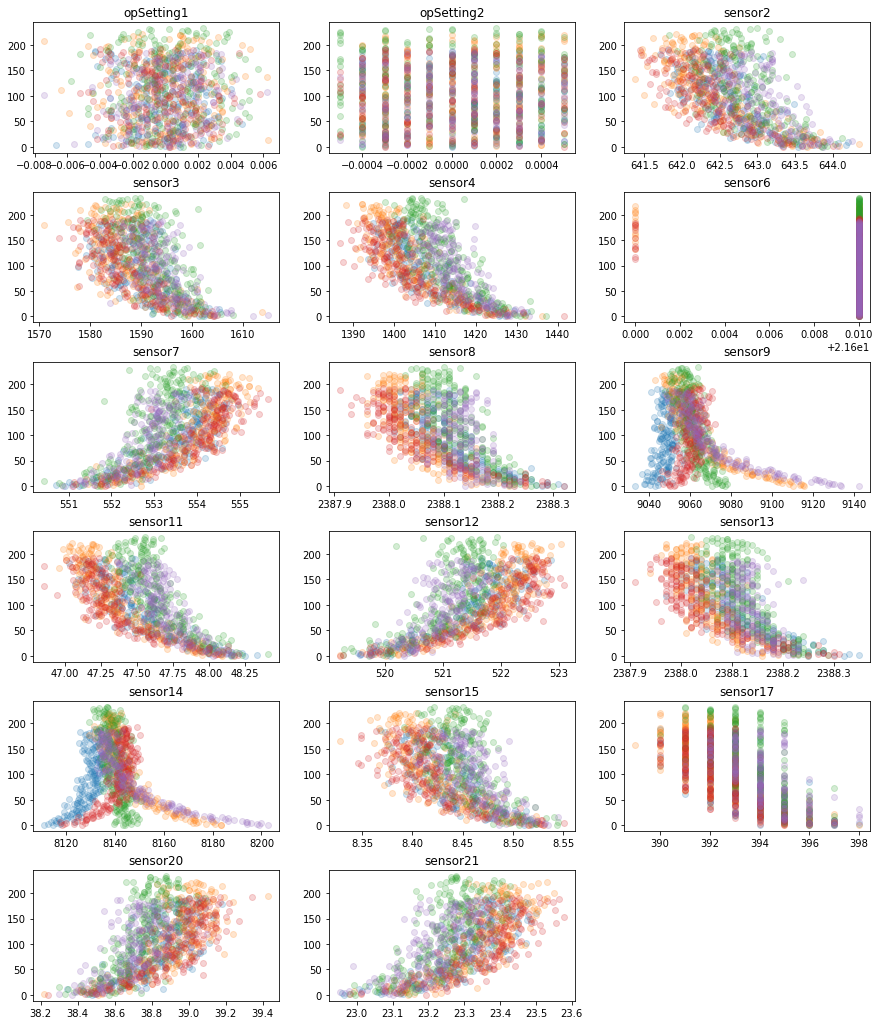

In [118]:
unit_num_list = [1, 10, 20, 30, 40]

colList = train.columns[1:-1]
n_cols = 3
rows = int(np.ceil(len(colList) / n_cols))    # 4 plots per row
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    
    axi = f.add_subplot(rows, n_cols, i+1)
    for i, unit_num in enumerate(unit_num_list):
        df = train[train.unit_num == unit_num]
        plt.scatter(df[col], df.CyclesToFailure, alpha = 0.2)# label = col + '_unit' + str(unit_num), alpha = 0.2)
        #df = train[[col, 'SalePrice']]
        #X = df.values
        #elenv = EllipticEnvelope(contamination=.001)
        #pred = elenv.fit_predict(X)
        #anom_index = np.where(pred==-1)
        #values = X[anom_index]

        #plt.scatter(values[:,0],values[:,1], color='r')
    plt.title(col)
        #axi.tick_params(axis="x", labelsize=7)
        #axi.tick_params(axis="y", labelsize=7)
        #locs,labels = plt.yticks()
    #plt.yticks(locs, map(lambda x: "%.1f" % x, locs/1e6))
    #plt.ylabel('1E6)')
    #plt.legend()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

In [ ]:

['sensor' + str(i) for i in range(1,29-7)]
#colsToDrop = 
#[train.columns[]]
#train.drop